# ns3でTCPの輻輳制御を観察する

## 環境構築

In [19]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set_style(style='ticks')

## グローバル変数

In [3]:
data_path = 'data/chapter4/' # データを保存するディレクトリ
save_path = '/home/vagrant/shared/' # 画像を保存するディレクトリ
# TCPアルゴリズム一覧
algorithms = [
    'TcpNewReno', 'TcpHybla', 'TcpHighSpeed', 'TcpHtcp', 
    'TcpVegas', 'TcpScalable', 'TcpVeno', 'TcpBic', 'TcpYeah', 
    'TcpIllinois', 'TcpWestwood', 'TcpLedbat']

In [21]:
# 保存用ディレクトリを作成．
if not os.path.exists(data_path):
    os.mkdir(data_path)
    
# 文字サイズ変更
plt.rcParams['font.size']=14

## 関数群

In [9]:
# コマンドライン引数を追加したコマンドを作成する関数
def make_command(
    algorithm=None, prefix_name=None, tracing=None, duration=None,
    bandwidth=None, delay=None, access_bandwidth=None, access_delay=None, 
    data=None, mtu=None, num_flows=None, flow_monitor=None, 
    pcap_tracing=None):
    
    """
    - algorithm: 輻輳制御アルゴリズム名．
    - prefix_name: 出力するファイルのプレフィックス名．pwdからの相対パスで表す．
    - tracing: トレーシング結果を行うか否か．
    - duration: シミュレーション時間[s]．
    - bandwidth: ボトルネック部分の帯域．例：'2Mbps'
    - delay: ボトルネック部分の遅延．例：'0.01ms'
    - access_bandwidth: アクセス部分の帯域．例:'10Mbps'
    - access_delay: アクセス部分の遅延．例:'45ms'．
    - data: 送信するデータ総量[MB]
    """
    
    cmd = './waf --run "chapter4-base'
    if algorithm:
        cmd += ' --transport_prot={}'.format(algorithm)
    if prefix_name:
        cmd += ' --prefix_name={}'.format(prefix_name)
    if tracing:
        cmd += ' --tracing={}'.format(tracing)
    if duration:
        cmd += ' --duration={}'.format(duration)
    if bandwidth:
        cmd += ' --bandwidth={}'.format(bandwidth)
    if delay:
        cmd += ' --delay={}'.format(delay)
    if access_bandwidth:
        cmd += ' --access_bandwidth={}'.format(access_bandwidth)
    if access_delay:
        cmd += ' --access_delay={}'.format(access_delay)
    cmd += '"'
    
    return cmd

In [10]:
# {prefix_name}{metric}.dataを読みだす関数
def read_data(prefix_name, metric, duration):
    
    file_name = '{}{}.data'.format(prefix_name, metric)
    data = pd.read_table(
        file_name, names=['sec', 'value'], delimiter=' ')
    data = data[data.sec <= duration].reset_index(
        drop=True)
    
    # 作画用に，最終行にduration秒のデータを追加．
    if duration > data.sec.max():
        tail = data.tail(1)
        tail.sec = duration
        data = pd.concat([data, tail])
    return data

In [11]:
# metricの時系列変化をプロットする関数．
# y_denoは単位変換に用いる（byte->segment）
def plot_metric(
    metric, x_max, y_label, y_deno=1, x_ticks=False):
    
    plt.step(
        metric.sec, metric.value/y_deno, 
        c='k', where='pre')
    plt.xlim(0, x_max)
    plt.ylabel(y_label)
    
    # x軸のメモリを表示するか否か．
    if x_ticks:
        plt.xlabel('time[s]')
    else:
        plt.xticks([])

In [12]:
# cong_stateの時系列変化をプロットする関数．
def plot_cong_state(
    cong_state, x_max, y_label, x_ticks=False):    
    # 2:rcwは今回の分析対象外なので，
    # 3，4を一つ前にずらす．
    new_state = {
        0:0 , 1:1, 3:2, 4:3}

    # 最初はOpen状態．
    plt.fill_between(
        [0, x_max],
        [0, 0],
        [1, 1],
        facecolor='gray')
    
    # 各輻輳状態ごとに該当秒数を塗りつぶす．
    for target_state in range(4):
        for sec, state in cong_state.values:
            if new_state[state]==target_state:
                color = 'gray'
            else:
                color = 'white'
            
            plt.fill_between(
                [sec, x_max], 
                [target_state, target_state],
                [target_state+1, target_state+1],
                facecolor=color)
    
    # 各服装状態を区切る横線を描画．
    for i in range(1, 4):
        plt.plot([0, x_max], [i, i], 'k-')
    
    plt.xlim(0, x_max)
    plt.ylim(0, 4)
    plt.yticks(
        [0.5, 1.5, 2.5, 3.5], 
        ['open', 'disorder', 'recovery', 'loss'])
    plt.ylabel(y_label)
    
    # x軸のメモリを表示するか否か．
    if x_ticks:
        plt.xlabel('time[s]')
    else:
        plt.xticks([])

In [20]:
# algorithmのcwnd，ssth，ack，rtt，cong-stateをプロットする関数．
def plot_algorithm(algo, duration, save_path):
    path = '{}{}/'.format(save_path, algo)

    # データの読み込み
    cwnd = read_data(path, 'cwnd', duration)
    ssth = read_data(path, 'ssth', duration)
    ack = read_data(path, 'ack', duration)
    rtt = read_data(path, 'rtt', duration)
    cong_state = read_data(path, 'cong-state', duration)
    
    # 描画
    plt.figure(figsize=(12, 12))
    plt.subplot(5, 1, 1)
    plot_metric(cwnd, duration, 'cwnd[byte]', 1)
    plt.subplot(5, 1, 2)
    plot_metric(ssth, duration, 'ssth[byte]', 1)
    plt.subplot(5, 1, 3)
    plot_metric(ack, duration, 'ack[byte]', 1)
    plt.subplot(5, 1, 4)
    plot_metric(rtt, duration, 'rtt[s]')
    plt.subplot(5, 1, 5)
    # 一番下のプロットのみx軸を描画．
    plot_cong_state(
        cong_state, duration, 'cong-state', 
        x_ticks=True)
    
    # 保存
    plt.savefig('{}04_{}.png'.format(
        save_path, algo.lower()))

In [22]:
def execute_and_plot(
    algo, duration, save_path, 
    bandwidth=None, delay=None, access_bandwidth=None, access_delay=None, 
    data=None, mtu=None, num_flows=None, flow_monitor=None, 
    pcap_tracing=None):
    
    # 保存用ディレクトリを作成．
    path = '{}{}/'.format(save_path, algo)
    if not os.path.exists(path):
        os.mkdir(path)
        
    cmd = make_command(
        algorithm=algo, tracing=True, 
        duration=duration, prefix_name=path,
        bandwidth=bandwidth, delay=delay, 
        access_bandwidth=access_bandwidth, 
        access_delay=access_delay, 
        data=data, mtu=mtu, num_flows=num_flows, 
        flow_monitor=flow_monitor, 
        pcap_tracing=pcap_tracing)
    
    print('Executing ns-3 command...')
    subprocess.check_output(cmd, shell=True).decode()
    
    print('Plotting...')
    plot_algorithm(algo, duration, save_path)

## 実験

全アルゴリズムについて，シミュレーションを実行する．

-- TcpNewReno --
Executing ns-3 command...
Plotting...
-- TcpHybla --
Executing ns-3 command...
Plotting...
-- TcpHighSpeed --
Executing ns-3 command...
Plotting...
-- TcpHtcp --
Executing ns-3 command...
Plotting...
-- TcpVegas --
Executing ns-3 command...
Plotting...
-- TcpScalable --
Executing ns-3 command...
Plotting...
-- TcpVeno --
Executing ns-3 command...
Plotting...
-- TcpBic --
Executing ns-3 command...
Plotting...
-- TcpYeah --
Executing ns-3 command...
Plotting...
-- TcpIllinois --
Executing ns-3 command...
Plotting...
-- TcpWestwood --
Executing ns-3 command...
Plotting...
-- TcpLedbat --
Executing ns-3 command...
Plotting...


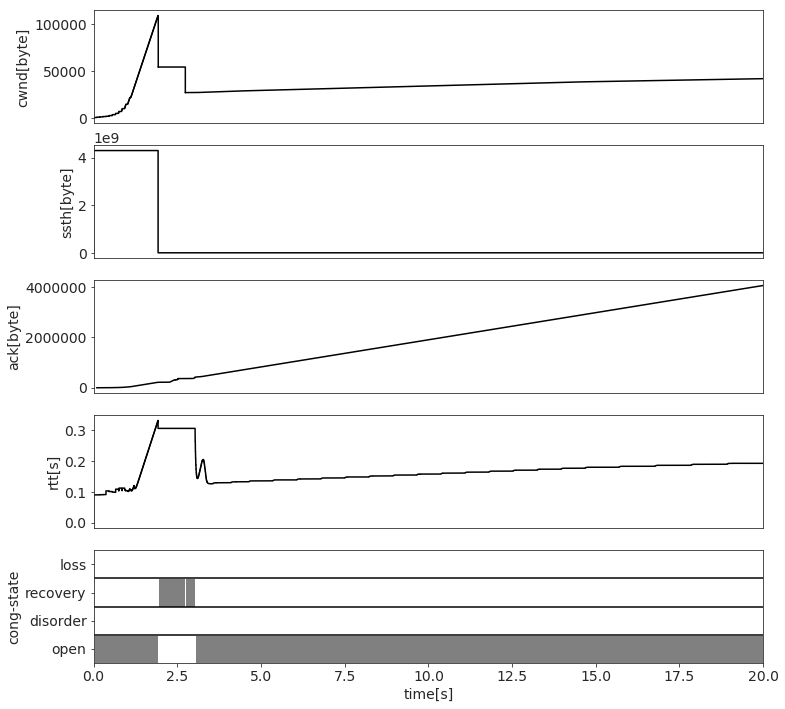

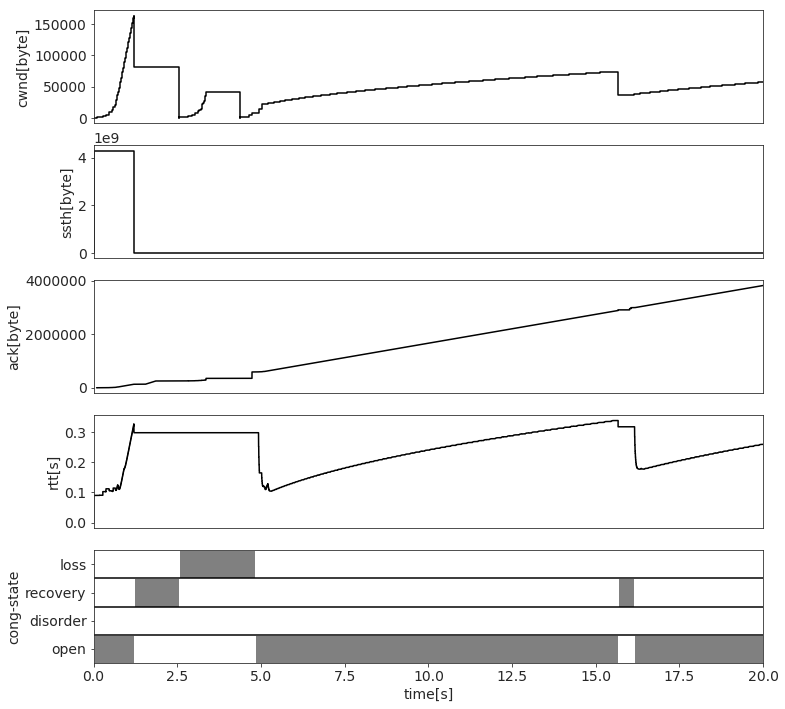

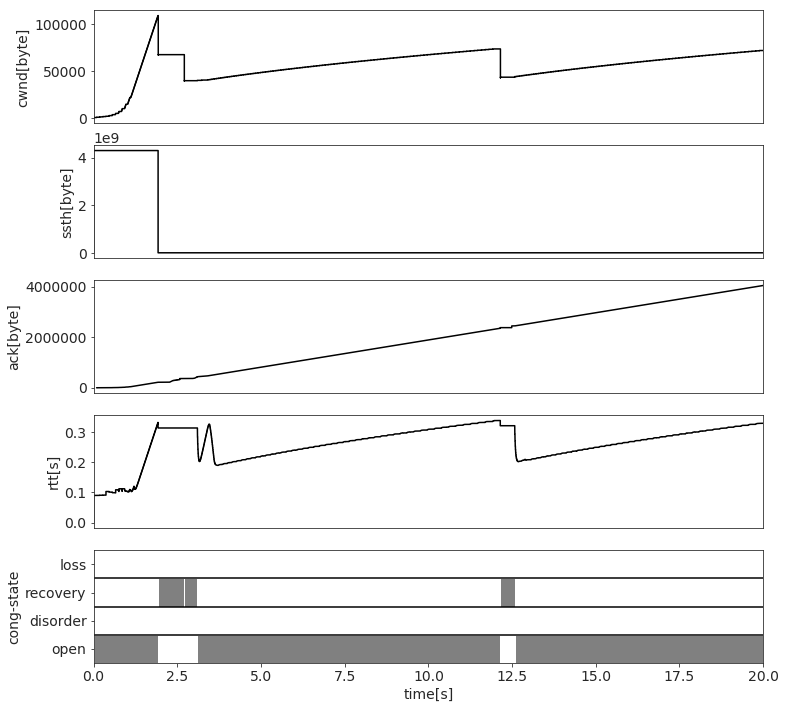

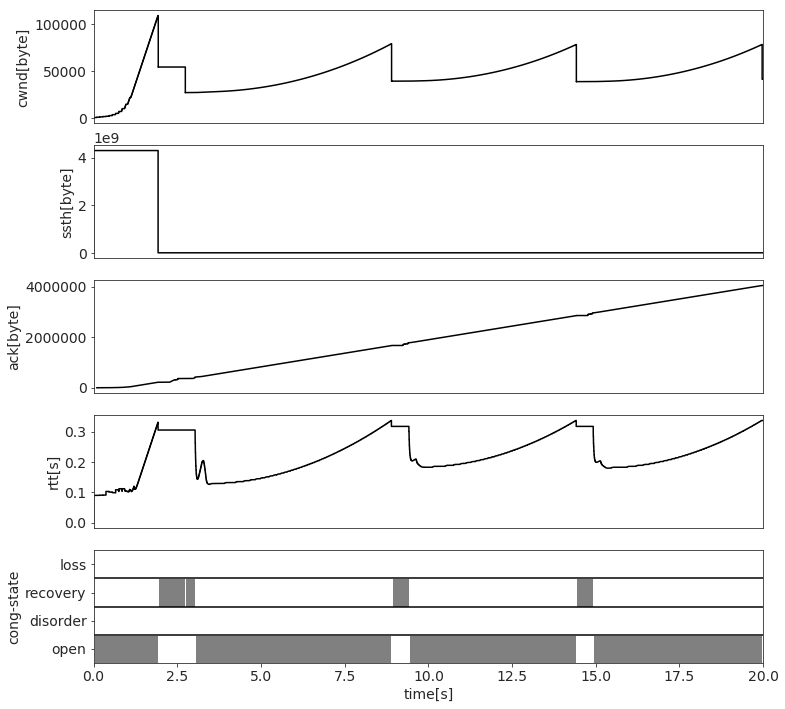

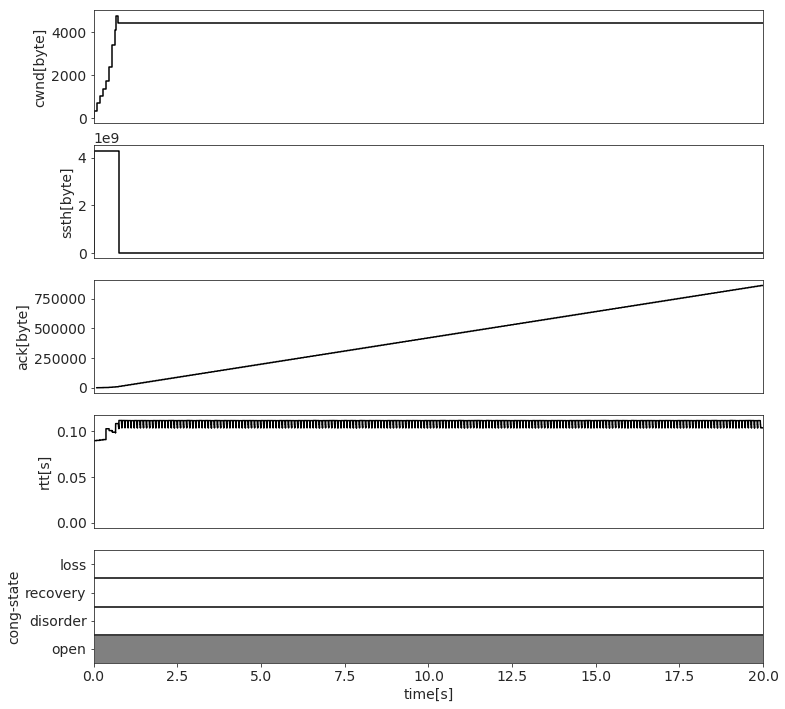

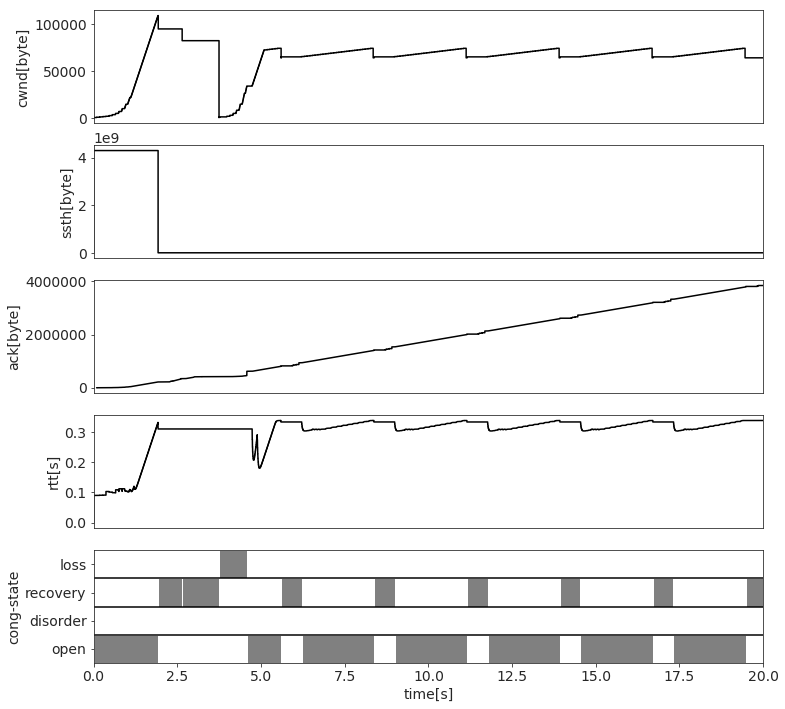

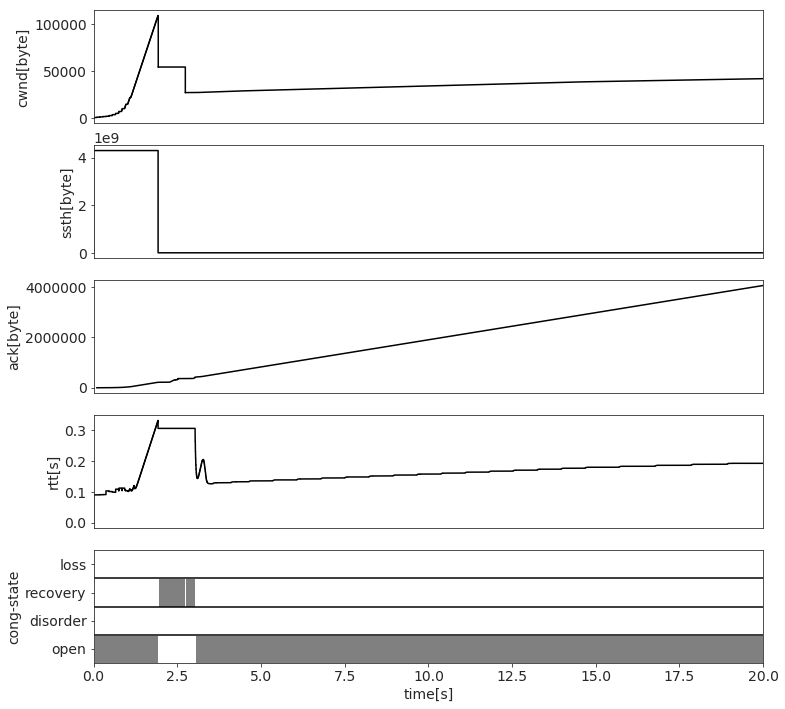

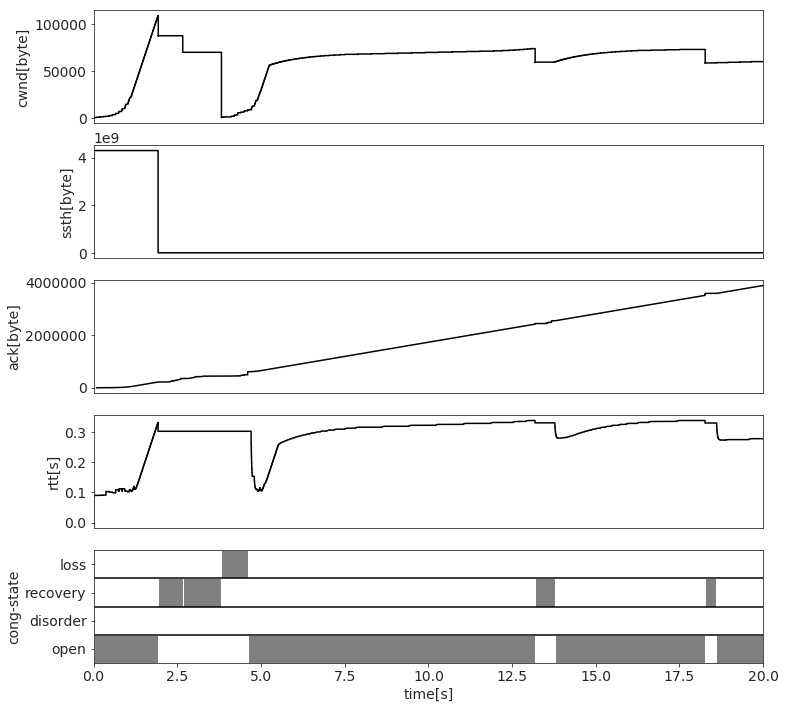

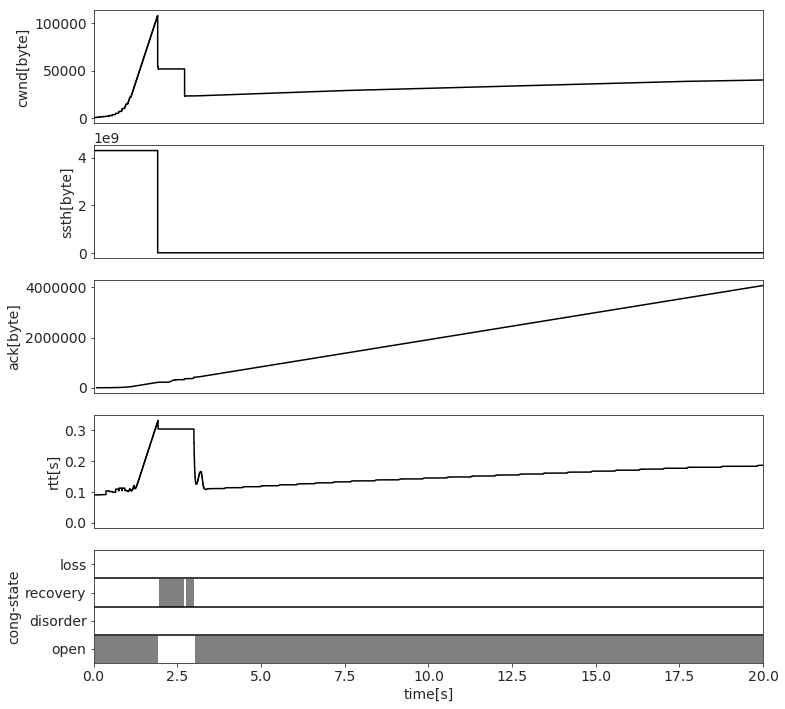

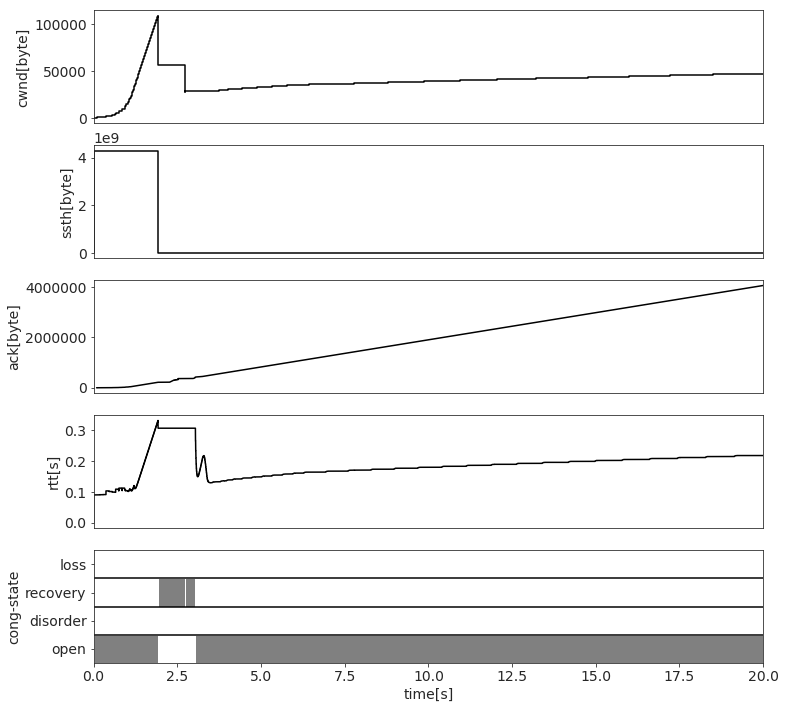

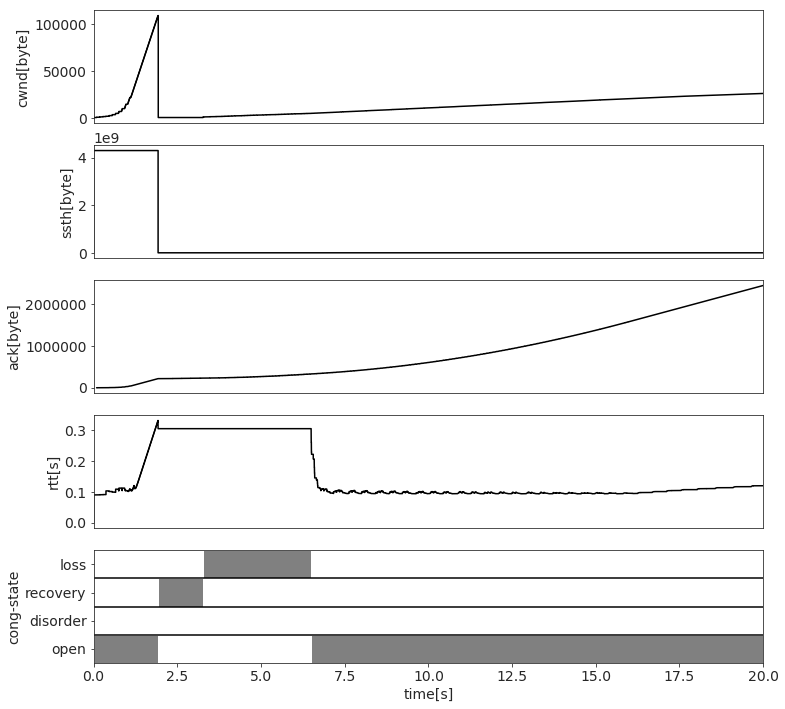

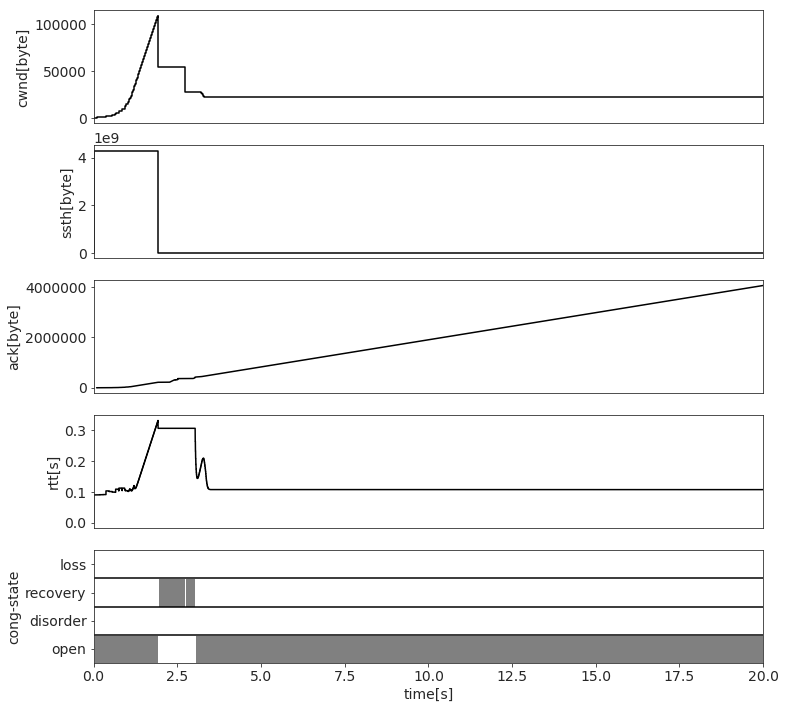

In [28]:
for algo in tqdm(algorithms, desc='Algotirhms'):
    print('-- {} --'.format(algo))
    execute_and_plot(algo, 20, data_path)